In [27]:
import gc
import sys

import matplotlib.pyplot as plt
import numpy as np

In [28]:
sys.path.append('..')
gc.enable()

# 自然言語と単語の分散表現

## 自然言語処理

### 単語の意味

## シソーラス

### WordNet

### シソーラスの問題点

- 時代の変化に対応できない
- 人の作業コストが高い
- 単語の細かいニュアンスを表現できない

## カウントベースの手法

### Pythonによるコーパスの下準備

In [9]:
text = 'You say goodbye and I say hello.'

In [10]:
text = text.lower()
text

'you say goodbye and i say hello.'

In [11]:
text = text.replace('.', ' .')
text

'you say goodbye and i say hello .'

In [12]:
words = text.split(' ')
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [13]:
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [14]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [15]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [17]:
corpus = [word_to_id[w] for w in words]
corpus

[0, 1, 2, 3, 4, 1, 5, 6]

In [18]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    
    word_to_id = {}
    id_to_word = {}
    
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    
    corpus = [word_to_id[w] for w in words]
    
    return corpus, word_to_id, id_to_word

In [19]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

In [20]:
corpus

[0, 1, 2, 3, 4, 1, 5, 6]

In [21]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [22]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

### 単語の分散表現

### 分布仮説

### 共起行列

In [29]:
del preprocess
gc.collect()

2575

In [30]:
from common.util import preprocess

In [31]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

In [32]:
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [33]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [38]:
# 共起行列を手でうちこむ
C = np.array([
    [0, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 1, 1, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 0],
], dtype=np.int32)

In [39]:
C[0]

array([0, 1, 0, 0, 0, 0, 0], dtype=int32)

In [40]:
C[word_to_id['goodbye']]

array([0, 1, 0, 1, 0, 0, 0], dtype=int32)

In [43]:
from common.util import create_co_matrix

### ベクトル間の類似度

In [44]:
def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x**2) + eps))
    ny = y / (np.sqrt(np.sum(y**2) + eps))
    return np.dot(nx, ny)

In [45]:
del cos_similarity
gc.collect()

1332

In [46]:
from common.util import preprocess, create_co_matrix, cos_similarity

In [47]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

In [49]:
c0 = C[word_to_id['you']]
c0

array([0, 1, 0, 0, 0, 0, 0], dtype=int32)

In [51]:
c1 = C[word_to_id['i']]
c1

array([0, 1, 0, 1, 0, 0, 0], dtype=int32)

In [52]:
cos_similarity(c0, c1)

0.7071067691154799

### 類似単語のランキング表示

In [53]:
from common.util import preprocess, create_co_matrix, most_similar

In [54]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

In [55]:
most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


## カウントベースの手法の改善

### 相互情報量

In [56]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total // 100) == 0:
                    print('%.lf%% done' % (100*cnt/total))
    return M

In [59]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

In [60]:
np.set_printoptions(precision=3)
print('convariance matrix')
print(C)
print('_'*50)
print('PPMI')
print(W)

convariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
__________________________________________________
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


### 次元削減

### SVDによる次元削減

In [59]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

In [61]:
U, S, V = np.linalg.svd(W)

In [64]:
W[0]

array([0.   , 1.807, 0.   , 0.   , 0.   , 0.   , 0.   ], dtype=float32)

In [65]:
U[0]

array([ 3.409e-01,  0.000e+00, -1.205e-01, -3.886e-16, -9.323e-01,
       -1.110e-16, -2.426e-17], dtype=float32)

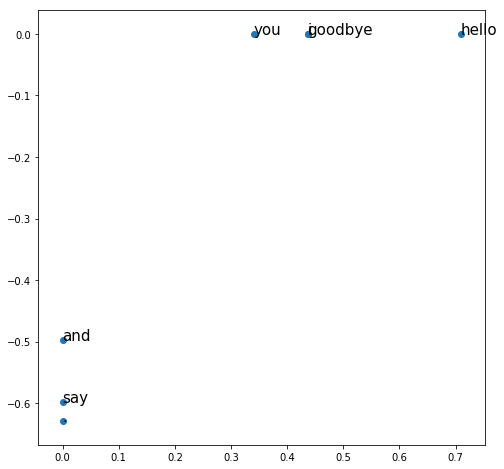

In [68]:
fig, ax = plt.subplots(figsize=(8, 8))
for word, word_id in word_to_id.items():
    ax.annotate(word, (U[word_id, 0], U[word_id, 1]), size=15)
ax.scatter(U[:, 0], U[:, 1])

### PTBデータセット

In [69]:
from dataset import ptb

In [70]:
corpus, word_to_id, id_to_word = ptb.load_data('train')

Done


In [72]:
print('corpus size:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

corpus size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


### PTBデータセットでの評価

In [74]:
from common.util import most_similar, create_co_matrix, ppmi
from dataset import ptb
from sklearn.utils.extmath import randomized_svd

In [76]:
window_size = 2
wordvec_size = 100

In [82]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('counting cooccurrence ...')
C = create_co_matrix(corpus, vocab_size, window_size)

counting cooccurrence ...


In [88]:
print('calculating PPMI ...')
W = ppmi(C, verbose=True)

calculating PPMI ...
1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.0% done
56.0% done
57.0% done
58.0% done
59.0% done
60.0% done
61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% done
73.0% done
74.0% done
75.0% done
76.0% done
77.0% done
78.0% done
79.0% done
80.0% done
81.0% done
82.0% done
83.0% done
84.0% done
85.0% done
86.0% done
87.0% done
88.0% done
89.0% done
90.0% don

In [94]:
print('calculating SVD ...')
U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)

calculating SVD ...


In [95]:
word_vecs = U[:, :wordvec_size]

In [96]:
word_vecs.shape

(10000, 100)

In [97]:
U.shape

(10000, 100)

In [98]:
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 i: 0.7171939015388489
 we: 0.6385721564292908
 do: 0.5657912492752075
 anybody: 0.529839813709259
 've: 0.5030631422996521

[query] year
 month: 0.6917464733123779
 earlier: 0.6332984566688538
 last: 0.6114604473114014
 quarter: 0.5875897407531738
 next: 0.5831531286239624

[query] car
 auto: 0.6196231245994568
 cars: 0.5978298187255859
 luxury: 0.5740803480148315
 truck: 0.5191361308097839
 vehicle: 0.5028477907180786

[query] toyota
 motor: 0.718635618686676
 nissan: 0.7126418948173523
 motors: 0.6279155015945435
 honda: 0.618651807308197
 lexus: 0.5517855882644653
